In [342]:
%load_ext autoreload

import utils as ut
import plot_tools as plt
import stat_tools as st
import pandas as pd
import plotly
import numpy as np

import scipy.stats as sps

%autoreload 2

plotly.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Notes

The data is extracted from the Binance API.

https://github.com/binance-exchange/binance-official-api-docs/blob/master/rest-api.md#klinecandlestick-data

Connection is made via the binance.py script, which enables local dump of the data

The data precision is 1 minute

Some studies have been made with different parameters (especially non-working ones), only one is included in the presentation in general

The notebook is still under construction

## Data

In [101]:
dataPath = "/home/charbel/Documents/Stanford/Project/data/"

In [102]:
data = ut.load_data(dataPath, "2019-07-01", "2019-12-31")
#data = ut.load_data(dataPath, "2019-01-01", "2019-12-31")
##PAXUSDT is a tether, we remove it
data = data[data.ticker != "PAXUSDT"]

100%|██████████| 184/184 [00:01<00:00, 107.35it/s]


In [103]:
##Indexing the data
data['close_time'] += 1
ut.index(data)

In [104]:
## Columns 
cols = ['close_time', 'ticker','close','volume_quote','buy_vol_quote','num_trades']
data = data[cols]
data.rename(columns = {'close_time':'t', 'close':'price', 'volume_quote':'volume', 'buy_vol_quote':'buy_vol'}, inplace=True)
data.eval('sell_vol = volume - buy_vol', inplace=True)

In [105]:
## Selecting tickers available from a certain date
start_dates = pd.to_datetime(data.groupby('ticker').first().t, unit='ms').sort_values()
tickers = start_dates[start_dates<='2019-07-02'].index
data.query('ticker in @tickers', inplace=True)

In [106]:
##Just to check if duplicates (API seems to send duplicates when data not available)
#t=data.groupby(['datetime','ticker']).count()
#t[t>=2].dropna()

In [107]:
data = data.drop_duplicates()

In [108]:
st.compute_volume(data, 'buy_vol', 'buy_vol_r', 60)
st.compute_volume(data, 'sell_vol', 'sell_vol_r', 60)
st.compute_volume(data, 'volume', 'volume_r', 60)

## Preliminary study

We compute the returns for 5 min, 1 hour, and 12 hours (different timescales)

In [109]:
st.compute_return(data, 'price', 'r5', 5)
st.compute_return(data, 'price', 'r60', 60)
st.compute_return(data, 'price', 'r720', 720)

#### Cross-sectional correlations

The returns become more correlated when the lookback is bigger (as expected)., we can observe some coins which seem more isolated

In [110]:
plt.plot_corr_heatmap(st.cross_correlation(data, 'r5'))
plt.plot_corr_heatmap(st.cross_correlation(data, 'r60'))
plt.plot_corr_heatmap(st.cross_correlation(data, 'r720'))

#### Lagged-sectional correlations

- Lagged returns (5min/1H/12H) on x-axis
- Blue diagonal represents self mean reversion

We would expect larger cryptocurrencies to lead smaller one. We observe this effect on the 5-min timescale and much less later. That means the leadlag effect is generally realized under an hour. For Bitcoin, the high liquidity allows this effect to realize on an even shorter scale (disappears in the 1-hour plot)

In [111]:
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r5', 5), False)
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r60', 60), False)
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r720', 720), False)

#### PCA

These heatmaps represent the principal components of the cross-sectional returns

The x-axis is labeled as the cumulative percentage of variance predited

We can see that the first component is stronger for longer lookbacks (in line with the higher observed correlations). The weightings on the first component are relatively uniform, that component represents the market return.

In [112]:
plt.plot_pca(data, 'r5')
plt.plot_pca(data, 'r60')
plt.plot_pca(data, 'r720')

In [113]:
##Cross sectional centering of the returns
st.cross_center(data, 'r5')
st.cross_center(data, 'r60')
st.cross_center(data, 'r720')

#### Residual reversion

We now center our returns cross-sectionally:

- We take the nonweighted average of returns per timestamp (the market return)
- We substract it from the individual returns

This computes a proxy for the market orthogonalized return, and allow us to more clearly observe the self mean-reversion effect of the assets.

The lagged correlation plot of the residuals is shown below

In [114]:
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r5-c', 5), False)
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r60-c', 60), False)
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r720-c', 720), False)

We observe high negative autocorrelation on the diagonal, which suggests a strong reversion effect. This effect is present over the course of a few minutes and hours, but disappears afterwards.

## Factor study

In this section we are going to benchmark different factor ideas. Factor potential should be benchmarked versus the market residual, defined by:

$$res^i_{m} = r^i - \beta^i*r_m$$

For simplicity we take the residual to be the cross-sectionally centered return, ie using $\beta_i=1, r_{market}=\bar{r^i}$

For now we are going to consider a frequency of 1 hour: 12 hours seems quite a long timespan for cryptocurrency (the reversion effect wasn't strong, meaning not many traders perform statistical arbitrage over this timespan) and 5 minutes would make it harder to have a profitable strategy given the linear fees.

Our methodology is as follow: for each factor idea, we will compute a metric accross the universe for each timestamp. We will rank the assets by timestamp with respect to this metric and observe the average residual per rank.

In [115]:
data = data[data.index.minute==0]
data['perf'] = data.groupby('ticker')['r60-c'].transform(lambda x: x.shift(-1))

### Mean-reversion

Mean-reversion is a very typical effect we observe on stocks. When orthogonalizing to the market or sector momentum effect, we observe a consistent negative autocorrelation of the residuals. That is due to a very low probability of consistently underperforming/outperforming the market or sector.

The previous plots leads us to think that this effect is similar for cryptocurrencies: they revert around the market return.

Our metric for this factor is going to be the past 1-hour return

$${MR}^i_t = -res^i_{m,t-1}$$

In [116]:
data['mr'] = -data['r60-c']

In [117]:
data['r']  = data.groupby('datetime')['mr'].rank('min')
plotData = data.groupby('r')['perf'].mean()
plt.plot_scatter(plotData.index, [plotData.values], [plotData.name])

As predicted by the previous plots we observe a strong relationship between a higher past return and a future lower one. Recent top performers perform worse in the future and vice-versa

### Volatility

Stock factor models often incorpore a volatility metric, which quantifies the risk linked to investing in a specific asset. The idea behind this reasoning is that more risky investments will tend to yield better returns, ie highly volatile stocks tend to outperform lower volatility ones.

We are going to experimentally test this effect on cryptocurrencies. For this we compute a short term and a long term volatility

$$shortvol^i_t = std(res^i_{m,t}, 12h)$$
$$longvol^i_t = std(res^i_{m,t}, 7D)$$

In [118]:
st.compute_volatility(data, 'r60', 'svol', 12)
st.compute_volatility(data, 'r60', 'lvol', 24*7)

In [119]:
data['r']  = data.groupby('datetime')['svol'].rank('min')
plt.plot_df(data.groupby('r')['perf'].mean())

In [120]:
data['r']  = data.groupby('datetime')['lvol'].rank('min')
plt.plot_df(data.groupby('r')['perf'].mean())

We observe similar results for both versions, volatility doesn't seem to yield a risk premium on cryptocurrencies, at least on an intraday basis.

### Volume

Another common factor in the stock market is size, which measures a company market capitalization. We usually observe higher returns on small caps. In the context of cryptocurrencies, we could think that ones with smaller market cap are still in expansion phase and are more likely to outperform the market. Unfortunately as of now we do not dispose of market cap data.

We are going to compute a cryptocurrency liquidity, as measured by its trailing volume over the past week

$$liq^i = volume(i, 7D)$$

We could maybe expect less popular cryptocurrencies to be growing. Although this effect has more chance to realize on a longer term (a couple of days), we can evaluate its predictability on the 1-hour returns

In [121]:
st.compute_volume(data, 'volume_r', 'liq', 24*7)

In [122]:
data['r']  = data.groupby('datetime')['liq'].rank('min')
plt.plot_df(data.groupby('r')['perf'].mean())

That factor doesn't seem to produce useful results. Prehaps it's worth trying to scrap the market capitalization data and compute a proper size factor

### Cash flow

Cryptocurrency markets, similarly to stock, work with a continuous double-auction mechanism. This introduces an asymetry between a taker (who sends a market order to the exchange) and a maker (who places an order on the book), regardless of the trader being a buyer or a seller. Market orders are believed to be more aggressive and tend to cost more (half of a spread at least), as the order is filled immediately.

Using other taker trader's informations is a successful strategies on stocks (in some situations), this can be naively done by computing an imbalance between the taker buy quantity and the taker sell quantity over a time period. We are going to compute this metric in our universe and evaluate its predictability. 

$$cf^i=\frac{buy\_volume(i, 1h) - sell\_volume(i, 1h)}{volume(i, 1h)}$$

In [123]:
data['cf'] = data.eval("(buy_vol_r-sell_vol_r)/(buy_vol_r+sell_vol_r)")

In [124]:
data['r']  = data.groupby('datetime')['cf'].rank('min')
plt.plot_df(data.groupby('r')['perf'].mean())

We get a quite surprising result, that is a negative correlation with the rank. The cashflow is a momentum indicator, we expect a positive correlation with the returns. However in our case, we already know that the residuals incorpore a strong reversion effect. By construction, the cashflow is correlated with the past return (buying/selling stocks induces instantaneous changes of prices, so we expect a stock under a buy pressure to have rosen in the past hour) so what we might see is the reversion effect.

In order to check whether this indicator has predictability, we will benchmark it against the returns we are going to obtain by residualizing further to the reversion effect. We are going to compute this residals later.

## Factor model

We are going to build on these ideas to construct a factor model which incorporates CAPM and our reversion indicator. The model can be written as:

$$r^i = \beta^ir_m + {MR}^ir_{mr} + res^i$$

where $r_{mr}$ is the return of the mean-reversion factor, and $r_m$ is the market return (to be defined).

Our methodology is the following:

- For each ticker i, compute $\beta^i$ by regressing $r^i$ over $r_m$ for each month. To avoid forward looking, the coefficients of month m will be used in month m+1
- For each ticker i, compute the market residual $res^i_m = r^i - \beta^ir_m$
- For each timestamp t, compute $r_{mr}$ by regressing $res^i_m$ over ${MR}^i$ (cross-sectional regression here)

In the future, a ticker's weight will refer to it's trailing volume over the past week

$$w^i = volume(i, 7D)$$

### Market return

Stock markets use commonly traded ETFs to represent market returns, thus $r_m$ corresponds to a weighted portfolio of stocks. To create an analog of the cryptocurrency market, we are going to consider 4 ideas:

- Equally weighted portfolio
- Weighting portfolio with $w^i$
- Weighting portfolio with $\sqrt{w^i}$
- Using Bitcoin as the market return (note that this prevents us from using Bitcoin as an asset in the model universe)

The equally weighted portfolio corresponds to the cross-centering of returns we executed previously. Weighting with the trailing volume will most likely put a heavy weight on Bitcoin which has a huge market share. We can omit the 4th version then, as the results will be similar to the weighted version. The square-root version is typical for stocks, it aims to tighten the gaps between the stocks, given that the traded volume distribution spans over multiple magnitudes.

In [125]:
st.compute_volume(data, 'volume_r', 'w', 24*7)
data['w'] = data.groupby('datetime')['w'].transform(lambda x: x/x.sum())
data['sqw'] = np.sqrt(data['w'])
data['sqw'] = data.groupby('datetime')['sqw'].transform(lambda x: x/x.sum())

In order to visualize our computation, we are going to look at the average weight of each ticker over the period

In [126]:
plt.plot_df(data.groupby('ticker')[['w','sqw']].mean())

As expected we observe a near dirac on Bitcoin for $w_i$, and the square-root version smoothens the differences out. It still keeps a heavy weight on Bitcoin though.

In [127]:
data['m60'] = data.groupby('datetime')['r60'].transform('mean')

In [128]:
data['period'] = data.index.month + 12*data.index.year
data['period'] -= data.period.min()

In [129]:
st.wmean(data, 'r60', 'w', 'm60-w')
st.wmean(data, 'r60', 'sqw', 'm60-sqw')

In [130]:
data[['m60', 'm60-w', 'm60-sqw']].corr()

,m60,m60-w,m60-sqw
m60,1.000000,0.915774,0.981981
m60-w,0.915774,1.000000,0.966315
m60-sqw,0.981981,0.966315,1.000000


The 3 versions are highly correlated. The square root being closer to an equally weighted portfolio, we observe higher correlation.

In order to pick a version, we are going to see if weighting helps improving the cross-centering we already have. In order to do this, we are going to look at the reversion potential of the residuals, and see if its stronger against the weighted portfolios.

In [131]:
data.eval('res_w = r60 - r60 - r60-w', inplace=True)
data.eval('res_sqw = r60 - r60 - r60-sqw', inplace=True)

In [132]:
plt.plot_corr_heatmap(st.lagged_correlation(data, 'r60-c', 1), False)
plt.plot_corr_heatmap(st.lagged_correlation(data, 'res_w', 1), False)
plt.plot_corr_heatmap(st.lagged_correlation(data, 'res_sqw', 1), False)

The autocorrelation plots of the 3 versions suggest a better uniformity for the equally-weighted portfolio, it seems to work better accross cryptocurrencies. We notice however that the weighted versions help reduce the outlying positive autocorrelation of Bitcoin. As our goal is to cover a broader universe, we will not give significant preference to this

To evaluate the strength of the signal, we are going to measure proxy returns and a proxy sharpe ratio. These metrics correspond to replicating a simple strategy which consists in holding at each timestamp $t$ a position on asset $i$ proportional to ${MR}^i_t$.

The metrics are therefore given by:

$$ret({MR}_t) = \frac{\sum_i{{MR}^i_tr^i}}{\sum_i{|{MR}^i_t|}}$$

$$ret(MR) = mean(ret({MR}_t))$$

$$sr(MR) = \frac{ret(MR)}{std(ret({MR}_t))}$$

In [133]:
st.pred_stats(data, 'r60-c', 'perf')

,return,sharpe
0,-10.416865,-0.204516


In [134]:
data['perf'] = -data.groupby('ticker')['res_w'].transform(lambda x: x.shift(-1))
st.pred_stats(data, 'res_w', 'perf')

,return,sharpe
0,7.298636,0.096832


In [135]:
data['perf'] = -data.groupby('ticker')['res_sqw'].transform(lambda x: x.shift(-1))
st.pred_stats(data, 'res_sqw', 'perf')

,return,sharpe
0,7.29874,0.09683


The results confirm our observations, the cross-sectionally centered return revert better accross the universe than their weighted counterparts. From now on $r_m$ will refer to the equally-weighted portfolio.

### Model

We first compute the betas issued from the rolling regression. The function regresses the returns over the market returns, outputs the betas for each ticker and residualize the returns using the coefficient of the past month.

In [136]:
#Removing null values from shifts
datan = data.loc["2019-07-02":]

In [137]:
beta = st.exposure_regression(datan, 'r60', 'm60', 'mres60')

In [138]:
plt.plot_df(pd.DataFrame(np.array([beta[t].values.T[0] for t in beta.keys()]).T, columns = beta.keys()))

The betas does not span over a very wide range as we can see, and they seem to be quite stable through the period. That is pretty reassuring, as the market portfolio will rarely have to change.

In [139]:
plt.plot_corr_heatmap(st.lagged_correlation(datan, 'mres60', 1), False)

The model residuals (which are very close to the cross-sectionally centered returns, given that the betas are all close to 1) exhibits the desired reversion behaviour. We note the same Bitcoin singularity, for which the residuals seem to be autocorrelated.

We will now compute the mean-reversion exposures, as the opposite of the previous residual for each ticker. We will execute the regression that outputs us the vector of mean-reversion returns

In [140]:
datan['mr'] = -datan.groupby('ticker')['mres60'].transform('shift')
datan['lmr'] = datan.groupby('ticker')['mr'].transform(lambda x: x.rolling(5).mean().shift())

In [141]:
datan = datan.loc["2019-08-02":]

In [142]:
fret = st.return_regression(datan, 'mres60', ['mr'])

In [143]:
datan = datan.combine_first(fret)

For each factor in a factor model, we can construct what is called the replicating portfolio. This portfolio is a linear combination of the assets and replicates the factor's return. Indeed, let us consider the factor model

$R_t = B_tf_t + RES_t$

where $R_t$ is the vector of asset returns, $B_t$ is the matrix of factor exposures, $f_t$ is the vector of factor returns, $RES_t$ is the residual 

The minimization that yields $f_t$ is a least-squares so we can write the explicit solution

$f_t = (B_t^TB_t)^{-1}B_tR_t$

The row $(F_t)_k$ of matrix $F_t = (B_t^TB_t)^{-1}B_t$ corresponds to the k-th factor's replicating portfolio, indeed we have $f_t = F_tR_t$

In [144]:
fport = datan.groupby('datetime').apply(lambda x: st.replicating_portfolio(x, ['mr'])).reset_index(level=1, drop=True)

In [145]:
plt.plot_df(1e-2*(fret['r60_mr']/np.abs(fport).sum(axis=1)).cumsum(), mode='lines')

This factor is a directional factor: contrarily to the market return, its mean is nonzero and following it yields positive returns. As shown in the plot above, the replicating portfolio performs very well over the period.

In [146]:
datan['res'] = datan.eval('mres60 - mr*r60_mr')

In [147]:
datan['pred'] = datan.eval('(r60-mres60) + mr*r60_mr')

In [148]:
plt.plot_pca(datan, 'res')

The PCA of the model residuals shows already much less correlation between the assets. In the first component, we can distinguish positive weight in particular for currencies traded on the Coinbase widely popular exchange (Bitcoin, Euthereum, Litecoin). We can pursue more on that idea later.

## Advanced studies

Here we follow on more ideas that could help us refine our model

### Residual cashflow

We saw previously that the cashflow metric yielded negative returns, probably because of its correlation with the reversion effect. We can benchmark the indicator on the new reversion-orthogonalized returns

In [149]:
datan['perf'] = datan.groupby('ticker')['res'].transform(lambda x: x.shift(-1))

In [150]:
datan['r']  = datan.groupby('datetime')['cf'].rank('min')
plt.plot_df(datan.groupby('r')['perf'].mean())

We can see that residualization indeed eliminated the reversion effect. However, this indicator does not yield momentum here. A possible cause would be its realization over a much shorter term (when we capture the pressure, the price move already realized)

### Reversion potential

In [151]:
datan['perf'] = datan.groupby('ticker')['res'].transform(lambda x: x.shift(-1))

In [152]:
plt.plot_corr_heatmap(st.lagged_correlation(datan, 'res', 1), False)

The figure above shows the autocorrelation plot of the fully residualized returns. We observe a singularity for Bitcoin, which is due to its reversion being realized quicker. To see if this effect is worth investigating, we examine its consistency through time. 

For this we benchmark the reversion of the fully-residualized return using the proxy return metric described previously. We compute the cumulative sum of the returns over the period.

In [153]:
plt.plot_df(datan.query("ticker=='BTCUSDT'").eval('res*perf/abs(res)').cumsum())

This quite steady upwards curve supports time consistency of this effect. As it is present on one single asset, we won't address it directly, however it can be the basis of the idea of reversion potential.

We assume that assets undergo momentum and reverting periods. Instead of assuming the asset will always revert, we compute its return autocorrelation over 2 days, and use it to condition the reversion indicator

$${Rpot}^i = -ac(res^i, 2D)$$

$$sig^i = {Rpot}^i*{MR}^i$$


In [154]:
datan['rpot'] = datan.eval('num=mr*mres60').groupby('ticker')['num'].transform(lambda x:x.rolling(48).mean()) / datan.groupby('ticker')[['mr','mres60']].transform(lambda x: x.rolling(48).std()).eval('mr*mres60')

In [155]:
plt.plot_df(datan.groupby('ticker')['rpot'].mean())

The mean of the computed reversion potential matches our expectations: positive for all cryptocurrencies except Bitcoin (which had a momentum tendency)

In [156]:
datan['perf'] = datan.groupby('ticker')['mres60'].transform(lambda x: x.shift(-1))

In [157]:
plt.plot_df(
    pd.merge(
        datan.eval('sig = -mres60*rpot').groupby('ticker')['perf','sig'].apply(lambda x: x.corr().iat[0,1]).rename('signal'),
        datan.eval('sig = -mres60').groupby('ticker')['perf','sig'].apply(lambda x: x.corr().iat[0,1]).rename('benchmark'),
        left_index=True,
        right_index=True
    )
)

This plot shows the correlation of this signal with the forward residuals, benchmarked against the regular reversion indicator. The new signal improves Bitcoin condition as expected, however it yields lower returns overall. Because of the added complexity we will stick with the regular indicator in the model.

### Long term mean-reversion

For now we incorporated an immediate mean reversion factor. Market participants include traders that consider different time scales in their analysis, so we could try to analyze a longer term mean reversion effect. Here we present the 6-hour mean reversion effect. To compute the indicator, we use the following formula:

$$\frac{1}{5}\sum_{s=t-1}^{t-6}{{MR}^i_s}$$

Note that we do not include the mean reversion at time $t$, we just consider what happened between 6-hours before and 1-hour before (as the short term reversion is already incorporated)

In [158]:
datan['lmr'] = datan.groupby('ticker')['mr'].transform(lambda x: x.rolling(5).mean().shift())

In [159]:
datan['r']  = datan.groupby('datetime')['lmr'].rank('min')
plotData = datan.groupby('r')['res'].mean()
plt.plot_scatter(plotData.index, [plotData.values], [plotData.name])

Performance is increasing with the rank, so this effect adds to the predictability of residuals. We can thus create a new factor based on this metric.

### Sharpe

We compute the past day sharpe ratio, to see if steadiness in the returns induce less reversion.

In [160]:
datan['sharpe'] = datan.groupby('ticker')['mres60'].transform(lambda x:x.rolling(24).mean()/x.rolling(24).std())

In [161]:
plt.plot_df(
    pd.merge(
        datan.eval('sig = -sharpe').groupby('ticker')['perf','sig'].apply(lambda x: x.corr().iat[0,1]).rename('signal'),
        datan.eval('sig = -mres60').groupby('ticker')['perf','sig'].apply(lambda x: x.corr().iat[0,1]).rename('benchmark'),
        left_index=True,
        right_index=True
    )
)

## Model evolution

Let's take back the preceeding model and use our observations to try to enhance its predictability. We are going to focus on the two ideas:

- Further past returns seem to exhibit a reversion potential too, our reversion indicator might be stronger if we incorporate this effect. We will add a style factor based on the long-term reversion indicator.
- PCA seems to suggest the importance of some cryptocurrencies, in particular the "main" ones traded on the Coinbase exchange (BTC, ETH, LTC). We can use that to construct a second-order market portfolio based on these cryptocurrencies, hoping to capture more variance than the basic model. We can compute the returns of this 3-cryptocurrency portfolio, and evaluate the exposures of each asset in our universe to this portfolio.

The new model, consisting of 2 fundamentals and 2 style factors, can be written:

$$r^i = \beta^ir_m + \gamma^ir_{cb} + {SMR}^ir_{smr} + {LMR}^ir_{lmr} + res^i$$

Because the market is already included in the model, $r_cb$ is the excess return of the Coinbase portfolio to the market (we want to separate exposures to the market, and exposures to Coinbase's excess return)

$$r_{cb} = \frac{r_{BTC}+r_{ETH}+r_{LTC}}{3} - r_m$$

TO compute the exposures we use the following methodology:

- For each ticker i, compute $[\beta^i,\gamma^i]$ by regressing $r^i$ over [$r_m$,$r_{cb}$] for each month. To avoid forward looking, the coefficients of month m will be used in month m+1
- For each ticker i, compute the market/coinbase residual $res^i_{m,cb} = r^i - \beta^ir_m - \gamma^ir_{cb}$
- For each timestamp t, compute $[r_{smr},r_{lmr}]$ by regressing $res^i_{cb}$ over $[{MR}^i,{SMR}^i]$

### Fundamental factors

In [162]:
datan = data.loc["2019-07-02":]

In [163]:
datan['cb'] = datan.eval("ticker in ['BTCUSDT','LTCUSDT','ETHUSDT']")
st.wmean(datan, 'r60', 'cb', 'cb60')
datan['cb60'] -= datan['m60']

In [164]:
beta = st.exposure_regression(datan, 'r60', ['m60','cb60'], 'mcbres60')

In [165]:
plt.plot_df(pd.DataFrame(np.array([beta[t]["cb60"].values.T for t in beta.keys()]).T, columns = beta.keys()))

The exposures of the majority of assets to the Coinbase portfolio seems relatively stable. We notice the majority of cryptocurrencies around 0, but some quite correlated/anticorrelated to this portfolio. For example, XMR and EOS seem quite positively exposed (in line with what we observed with the PCA).

It's normal to observe negative exposures as the market is already taken into account here.

In [166]:
plt.plot_corr_heatmap(st.lagged_correlation(datan, 'mcbres60', 1), False)

The lagged correlation matrix looks more uniform accross tickers now. We added a midpoint between the Coinbase asset by introducing $r_{cb}$ in the model, and that allowed us to get rid of most of the Bitcoin self-trend. It is indeed normal to observe reversion now, as the Coinbase exchange trades pairs such as BTC/ETH or BTC/LTC which naturally induce a reversion towards the Coinbase portfolio.

### Style factors

In [167]:
datan['smr'] = -datan.groupby('ticker')['mcbres60'].transform('shift')
datan['lmr'] = datan.groupby('ticker')['smr'].transform(lambda x: x.rolling(5).mean().shift())

In [168]:
datan = datan.loc["2019-08-02":]
fret = st.return_regression(datan, 'mcbres60', ['smr','lmr'])
datan = datan.combine_first(fret)
datan['res'] = datan.eval('mcbres60 - smr*r60_smr - lmr*r60_lmr')

In [169]:
fport = datan.groupby('datetime').apply(lambda x: st.replicating_portfolio(x, ['smr','lmr']))
fret = fret/np.abs(fport).sum(axis=1).rename('ret').reset_index(level=1).pivot(columns='factor', values='ret').rename({'lmr':'r60_lmr', 'smr':'r60_smr'}, axis=1)
plt.plot_df(1e-2*fret.cumsum(), mode='lines')

The plot shows the returns of the style factors replicating portfolios over time. These factors are very directional and are the main driver of the cryptocurrency market residuals. The short-term reversion yields as expected stronger returns than the long-term one. Separating the two effects gives more trading freedom compared to sticking to one reversion factor.

In [170]:
plt.plot_corr_heatmap(st.lagged_correlation(datan, 'res', 1), False)

The factor model's aim is to stay uniform accross the universe. The Bitcoin having much less reversion potential than it's counterparts, we still see a positive autocorrelation of the residuals. The introduction of the Coinbase factor, however, reduced significantly this effect.

In [171]:
plt.plot_pca(datan, 'res')

A PCA on the new residuals shows:

- Less predictability by looking at the weights in each component
- Last component issued from the "manual" Coinbase residualization (very little variance associated though)
- Less variance explained by first component, so more independance accross the universe

In [ ]:
#datan['perf'] = datan.groupby('ticker')['res'].transform(lambda x: x.shift(-1))

In [ ]:
#datan.eval('pred = r60-mcbres60')[["r60","pred"]].corr()
#datan.eval('pred = r60-res')[["r60","pred"]].corr()

## More

### On mean-reversion

In this section we will get a better understanding of the cryptocurrency reversion timescales. For this we are going to compute past returns at different timescales:

- 1 min, 5 min: HF reversion indicators
- 15 min, 30 min, 60 min: Mid-frequency indicators
- 2h, 4h: Long-term indicator

We will not go past 4 hours unless needed (we have already seen before than 12 hours almost eliminate the reversion effect, so I don't expect it to be significant at +4h). All the returns are cross-sectionnally centered (what we want to look at is the residual reversion as usual).

For each of these indicators, we can compute the correlation with the future returns at different timescales. However, in order to compare correlations at different horizons, we need to multiply it by the standard deviation of the forward performance:

$nCov(X, Y) = \frac{Cov(X,Y)}{std(X)}$

That metric measures the "quantity" of return we are predicting at a certain horizon, instead of the percentage (which the correlation indicates).

We will consider HF and MF forward horizons in the study.

In [226]:
data = ut.load_data(dataPath, "2019-07-01", "2019-12-31")
data = data[data.ticker != "PAXUSDT"]
data['close_time'] += 1
ut.index(data)
cols = ['close_time', 'ticker','close','volume_quote','buy_vol_quote','num_trades']
data = data[cols]
data.rename(columns = {'close_time':'t', 'close':'price', 'volume_quote':'volume', 'buy_vol_quote':'buy_vol'}, inplace=True)
## Selecting tickers available from a certain date
start_dates = pd.to_datetime(data.groupby('ticker').first().t, unit='ms').sort_values()
tickers = start_dates[start_dates<='2019-07-02'].index
data.query('ticker in @tickers', inplace=True)
data = data.drop_duplicates()

100%|██████████| 184/184 [00:02<00:00, 89.89it/s] 


In [228]:
horizons = [1,5,15,30,60,120,240]
fwd_horizons = [10, 20, 30, 45, 60, 90, 120, 180, 240, 360, 720, 1440]
hf_horizons = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40, 50, 60, 90, 120]

In [229]:
for h in horizons:
    st.compute_return(data, 'price', 'r'+str(h), h)
    st.cross_center(data, 'r'+str(h))
for h in fwd_horizons:
    st.compute_return(data, 'price', 'p'+str(h), -h)
    st.cross_center(data, 'p'+str(h))
for h in hf_horizons:
    st.compute_return(data, 'price', 'p'+str(h), -h)
    st.cross_center(data, 'p'+str(h))

In [230]:
for i in range(len(horizons)-1):
    data['r'+str(horizons[i+1])+'-cr'] = data['r'+str(horizons[i+1])+'-c'] - data['r'+str(horizons[i])+'-c']

In [231]:
ncov = lambda x,y: np.mean(x*y)/np.std(x)

In [232]:
data = data.dropna()

In [234]:
plt.plot_scatter(fwd_horizons, [[-ncov(data['r'+str(h)+'-c'], data['p'+str(f)+'-c']) for f in fwd_horizons] for h in horizons], ['r'+str(h) for h in horizons])

In [235]:
plt.plot_scatter(hf_horizons, [[-ncov(data['r'+str(h)+'-c'], data['p'+str(f)+'-c']) for f in hf_horizons] for h in horizons], ['r'+str(h) for h in horizons])

These first 2 plots show the average predicted return for each reversion signal, as a function of the forward performance in minutes. The first plot corresponds to the longer term horizons.

We can see that short term performance is essentially driven by the short term past return: in the first few minutes the short term signals perform better than the long-term ones. At approximately 10 minutes the predictability of the short term return diminishes and the long term signals still realize.

An explanation for this is the presence of different trading strategies at different timescales on the market. A high-frequency trader will tend to focus on short term gains and will react quickly to the market movements, causing short term reversion. A more longer term trader however could be slowly building a portfolio and influencing the prices over a larger time scale.

The long term predictability of the signals greatly increases up to 1-hour until it seems to saturate. In terms of future predictability, reversions signals work up to 4-6h.

To gain insight on the independant predictability of the backward periods, we will consider a modified version of the returns which, similarly to the LTR signal before, orthogonalize to the preceeding one.

Example: $r_5 \leftarrow r_5 - r_1$, $r_{15} \leftarrow r_{15} - r_5$, ...

In [236]:
plt.plot_scatter(fwd_horizons, [[-ncov(data['r'+str(h)+'-cr'], data['p'+str(f)+'-c']) for f in fwd_horizons] for h in horizons[1:]], ['r'+str(h)+'-r' for h in horizons[1:]])

In [237]:
plt.plot_scatter(hf_horizons, [[-ncov(data['r'+str(h)+'-cr'], data['p'+str(f)+'-c']) for f in hf_horizons] for h in horizons[1:]], ['r'+str(h)+'-r' for h in horizons[1:]])

A few observations here. First it seems that the marginal predictability decreases after looking back 1-hour. The 4-hour marginal contribution is weaker. That reinforces the idea of using a (exponentially) weighted moving average when computing the lookback signal. Second, we see on the HF scale that longer lookbacks predict very slowly and smoothly the realization of returns in the first minutes. While weaker than the short-term signals, they lead the general trend.

We can think of reversion signals as oscillating with a different return to the mean parameter. We can think of reversion signals as Ornstein-Uhlenbeck processes

$$dX_t = -\epsilon X_t dt + \beta dW_t$$

for which $\epsilon$ controls the reversion speed. We can estimate it using actual data using the formula $\epsilon = \frac{Var(X_t)}{Cov(X_t, X_{t+1})}$

In [306]:
plt.plot_scatter(horizons[1:], [[st.computeOU(data,'r'+str(h)+'-c') for h in horizons[1:]]], 'eps')

We see that the parameter $\epsilon$ decreases exponentially with the horizon. A trading strategy could control a portfolio with a long term view, and execute its order on the peaks of the short-term signal. That would be a prediction-driven execution, likely to outperform the classic VWAP framework.

#### Larger vs Smaller cryptocurrencies

We already know that on some cryptocurrencies (such as Bitcoin), the reversion signals realize quicker than for others. To investigate on this, we will see whether volume can explain faster realizations. We computed portfolios of the 6 most traded and the 6 less traded cryptocurrencies (Top VS bottom analysis).

In [307]:
large = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "EOSUSDT", "LTCUSDT"]
small = ["OMGUSDT", "ENJUSDT", "ZRXUSDT", "ZILUSDT", "HOTUSDT", "WAVESUSDT"]

In [309]:
datal = data.query('ticker in @large')
datas = data.query('ticker in @small')

##### Large cluster

In [310]:
plt.plot_scatter(fwd_horizons, [[-ncov(datal['r'+str(h)+'-c'], datal['p'+str(f)+'-c']) for f in fwd_horizons] for h in horizons], ['r'+str(h) for h in horizons])

In [314]:
plt.plot_scatter(hf_horizons, [[-ncov(datal['r'+str(h)+'-c'], datal['p'+str(f)+'-c']) for f in hf_horizons] for h in horizons], ['r'+str(h) for h in horizons])

##### Small cluster

In [311]:
plt.plot_scatter(fwd_horizons, [[-ncov(datas['r'+str(h)+'-c'], datas['p'+str(f)+'-c']) for f in fwd_horizons] for h in horizons], ['r'+str(h) for h in horizons])

In [313]:
plt.plot_scatter(hf_horizons, [[-ncov(datas['r'+str(h)+'-c'], datas['p'+str(f)+'-c']) for f in hf_horizons] for h in horizons], ['r'+str(h) for h in horizons])

The 4 plots show the realization of the different signals, for the large and the small cluster both at a high-frequency and long-term. We see that both baskets seem to realize over 4-6 hours, the smaller assets yielding much better returns as expected. However, volume seems to have a strong effect on the short time scales, where the short lookbacks perform much better than the longer term one. High-frequency traders need liquidity and will probably tend to trade the larger cryptocurrencies.

## On new cryptocurrencies

In this section we digress on the inception of new cryptocurrencies on the market. If we manage to capture data for a cryptocurrency near its creation, we could benefit from the high volatility regimes that follow (in case we are able to predict these large movements).

We are going to look at the volume pattern that follows. We expect to see an increase in the first days, due to the creation of the cryptocurrency, followed by a stationnary regime, or a coninuously increasing one depending on the coin's popularity.

In order to compute that, we are going to consider all the cryptocurrencies appearing in our data in 2019, but before November. We are then going to re-center the time origin for each cryptocurrency at its inception, and compute our stats relative to this time (The zero is different for each coin).

- We associate a volume index to a day D for ticker i: $vn_{i,D} = \frac{volume_{i,D}}{mean(volume_{D})}$. This looks forward but will just be used for renormalization accross assets.
- We compute the the cross-sectional 10%-trimmed mean of $vn_{i,D}$

In [321]:
data = ut.load_data(dataPath, "2019-01-01", "2019-12-31")
data = data[data.ticker != "PAXUSDT"]
data['close_time'] += 1
ut.index(data)
cols = ['close_time', 'ticker','close','volume_quote','buy_vol_quote','num_trades']
data = data[cols]
data.rename(columns = {'close_time':'t', 'close':'price', 'volume_quote':'volume', 'buy_vol_quote':'buy_vol'}, inplace=True)
## Selecting tickers created in 2019 and starting before November (to have enough data)
start_dates = pd.to_datetime(data.groupby('ticker').first().t, unit='ms').sort_values()
tickers = start_dates[(start_dates<='2019-10-30') & (start_dates>="2019-01-02")].index
data.query('ticker in @tickers', inplace=True)
data = data.drop_duplicates()
st.compute_volume(data, 'volume', 'volume_r', 60)

100%|██████████| 365/365 [00:03<00:00, 100.07it/s]


In [322]:
data = data[data.index.minute==0]

In [323]:
data = data.merge(start_dates.rename('start'), on='ticker', right_index=True)

In [324]:
data['dinc'] = ((data.index - data['start']).astype(int)*1e-9)//86400

In [325]:
data['volume_d'] = data.groupby(['ticker', 'dinc'])['volume_r'].transform('sum')

In [444]:
ddata = data.groupby(['dinc','ticker']).last().reset_index(level=1).drop(['buy_vol', 'num_trades', 'volume_r', 'volume'], axis=1)

In [445]:
ddata['volume_dn'] = ddata.groupby('ticker')['volume_d'].transform(lambda x: x/x.mean())

In [446]:
plt.plot_df(ddata.groupby('dinc')['volume_dn'].apply(lambda x:sps.trim_mean(x, 0.1))[:200])

The volume patterns looks very IPO-like, with a lot of volume on average in the first few days, then a stationnary regime for the rest of the life cycle. Two possible reasons for that:

- The initial jump is realized over a few hours (most likely not enough to benefit from it)
- The coins were actually tradeable on another exchange before being traded on Binance

We will try to predict good performing coins based on their initial volume. Our indicator will compare the volume between 2 and 5 days with the volume on the first day. We expect higher ratios to be related to more excitement.

$$vr_i = \frac{\sum_{d=1}^{4} volume_{i,d}}{volume_{i,0}}$$

In [435]:
st.compute_return(ddata, 'price', 'p7d', -7)
st.cross_center(ddata, 'p7d')
st.compute_volume(ddata, 'volume_d', 'volume_4d', 4)

In [443]:
plt.plot_df(ddata.loc[4][['vr','p7d']].sort_values('vr').set_index('vr'))

This plot represents the cross-sectionally centered performance of 5 to day 12 (7 day performance). It shows very little to no correlation with our indicator. It is hard to derive results from this, as we only have 25 effective samples (the time dimension is removed)

## Makowitz factor investing (Draft, work in progress)

In [543]:
datan['mr'] = -datan.groupby('ticker')['mres60'].transform('shift')
datan['lmr'] = datan.groupby('ticker')['mr'].transform(lambda x: x.rolling(5).mean().shift())

In [536]:
for t in tmp.keys():
    tmp[t].columns = [t]

In [537]:
tmp = pd.concat(tmp.values(), axis=1).stack().reset_index()
tmp.columns = ['period', 'ticker', 'beta']

In [538]:
datan = datan.merge(tmp, on=['period','ticker'], right_index=True)

In [539]:
datan['mfres60'] = datan.eval('r60-beta*m60')

In [583]:
sigma = datan.groupby('period').apply(lambda x: st.cross_correlation(x, 'mfres60', False).values)

In [542]:
datan['fmr'] = -datan.groupby('ticker')['mfres60'].transform('shift')
datan['flmr'] = datan.groupby('ticker')['fmr'].transform(lambda x: x.rolling(5).mean().shift())

In [553]:
datan = datan["2019-07-03":]

In [556]:
coeffs = st.exposure_regression(datan, 'mfres60', ['fmr', 'flmr'], 'predres', ['mr', 'fmr'])

In [557]:
datan['expret'] = datan.eval('mfres60 - predres')

/home/charbel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [657]:
datan = datan.loc["2019-08-02":]

In [653]:
t=datan.loc["2019-08-04 00:00:00"].sort_values('ticker')

In [654]:
t['expret'].values.round(1)

array([  1. , -24.3,  10.8, -37.1, -13.7,   2. ,   3.3,   0.1,  -8.1,
         9.1,   4.6,   8.5,   0.1, -20.7,  -0.9,   1.6, -41.9,  -0.1,
        48.6,  -7.6,   0.7,   7.7,  14.2,  -4.5,  10.9,  11.2,   4.3,
         0.8,   3.7,  10.6,   7.4,   2. ])

In [681]:
st.targetPos(np.zeros(32), t['expret'].values, 0,  0.01, sigma[0]).round(2)

array([-0.  , -0.05,  0.04, -0.14, -0.06,  0.  , -0.  , -0.  , -0.  ,
        0.  ,  0.  ,  0.06, -0.  , -0.14,  0.  , -0.  , -0.1 ,  0.  ,
        0.18, -0.01,  0.  ,  0.  ,  0.09, -0.  ,  0.02,  0.01, -0.  ,
        0.  ,  0.  ,  0.09, -0.  , -0.  ])

In [675]:
res = st.markowitz(datan, 'mres60', 'expret', sigma, 0,  0)

/home/charbel/Documents/Stanford/Project/stat_tools.py:118: RuntimeWarning:

overflow encountered in double_scalars



In [695]:
res['return'].mean()/res['return'].std()

0.13644473001800014

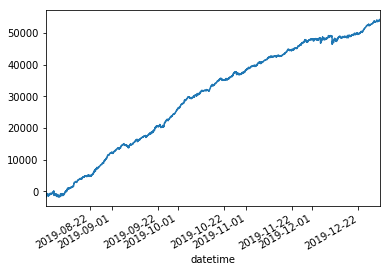

In [679]:
res['return'].cumsum().plot()

In [685]:
#res2 = st.markowitz(datan, 'mres60', 'expret', sigma, 0,  0.01)

In [692]:
res2['return'].mean()/res2['return'].std()

0.1565631704357344

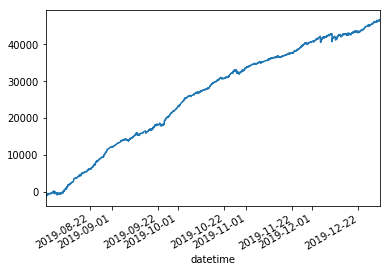

In [690]:
res2['return'].cumsum().plot()

In [691]:
res23 = st.markowitz(datan, 'mres60', 'expret', sigma, 0,  0.05)

In [701]:
res23['return'].mean()

8.21135712798237

In [697]:
res23['return'].mean()/res23['return'].std()

0.1928962736830171

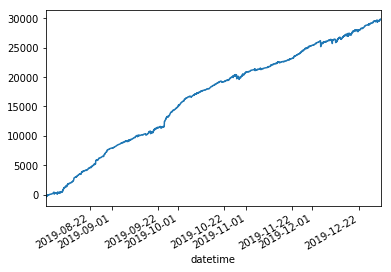

In [694]:
res23['return'].cumsum().plot()

In [698]:
res4 = st.markowitz(datan, 'mres60', 'expret', sigma, 0,  0.1)

In [699]:
res4['return'].mean()/res4['return'].std()

0.18513249735239998

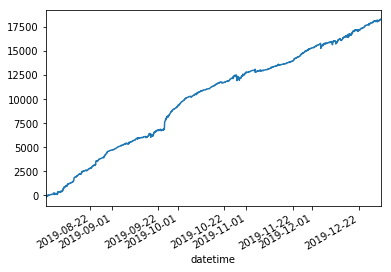

In [700]:
res4['return'].cumsum().plot()

In [9]:
import plotly.graph_objs as go
import plotly
import numpy as np

x = np.arange(-0.8, 0.9, 0.1)
y = np.arange(-0.8, 0.9, 0.1)
x, y = np.meshgrid(x,y)
rmin = x*y - np.sqrt((1-x**2)*(1-y**2))
rmax = x*y + np.sqrt((1-x**2)*(1-y**2))
r = x*y

fig = go.Figure(
    data=[
        go.Surface(x=x, y=y, z=rmin, name='rmin'), 
        go.Surface(x=x, y=y, z=rmax, name='rmax'),
        go.Surface(x=x, y=y, z=r, name='r')
    ])
plotly.offline.iplot(fig)